## 1. Imports & Setup

Initializes libraries, model classes, and tools. Sets plotting style and ensures the model directory exists.

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import glob
import re
import warnings

# Models
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Sklearn Tools
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.pipeline import Pipeline

# Setup plotting
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

# Create final models folder if it doesn't exist
save_dir = "../Model_Training/Trained_Models/Marketing"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Created directory: {save_dir}")

## 2. Load & Preprocess Data

Loads the cleaned dataset

In [54]:
# FIND FILE AUTOMATICALLY
files = glob.glob("../Datasets/Cleaned_Datasets/Marketing/*.csv")

if not files:
    raise FileNotFoundError("No CSV files found. Check your path!")

files.sort()

print(f"Loading file: {files[0]}")
df = pd.read_csv(files[0])
print(f"Final Data Shape: {df.shape}")

Loading file: ../Datasets/Cleaned_Datasets/Marketing\marketing_cleaned_prepared.csv
Final Data Shape: (72206, 20)


## 3. Feature Engineering & Selection

Defines the target variable, removes potential data leakage, splits the data, and selects the top 10 most relevant features.

Dropped Leakage: ['overcost', 'campaign_item_id', 'media_cost_usd', 'clicks', 'impressions', 'Unnamed: 0']

🔍 Training Inspector Models to compare Feature Importance...
   -> Analyzing with RandomForest...
   -> Analyzing with XGBoost...
   -> Analyzing with LightGBM...


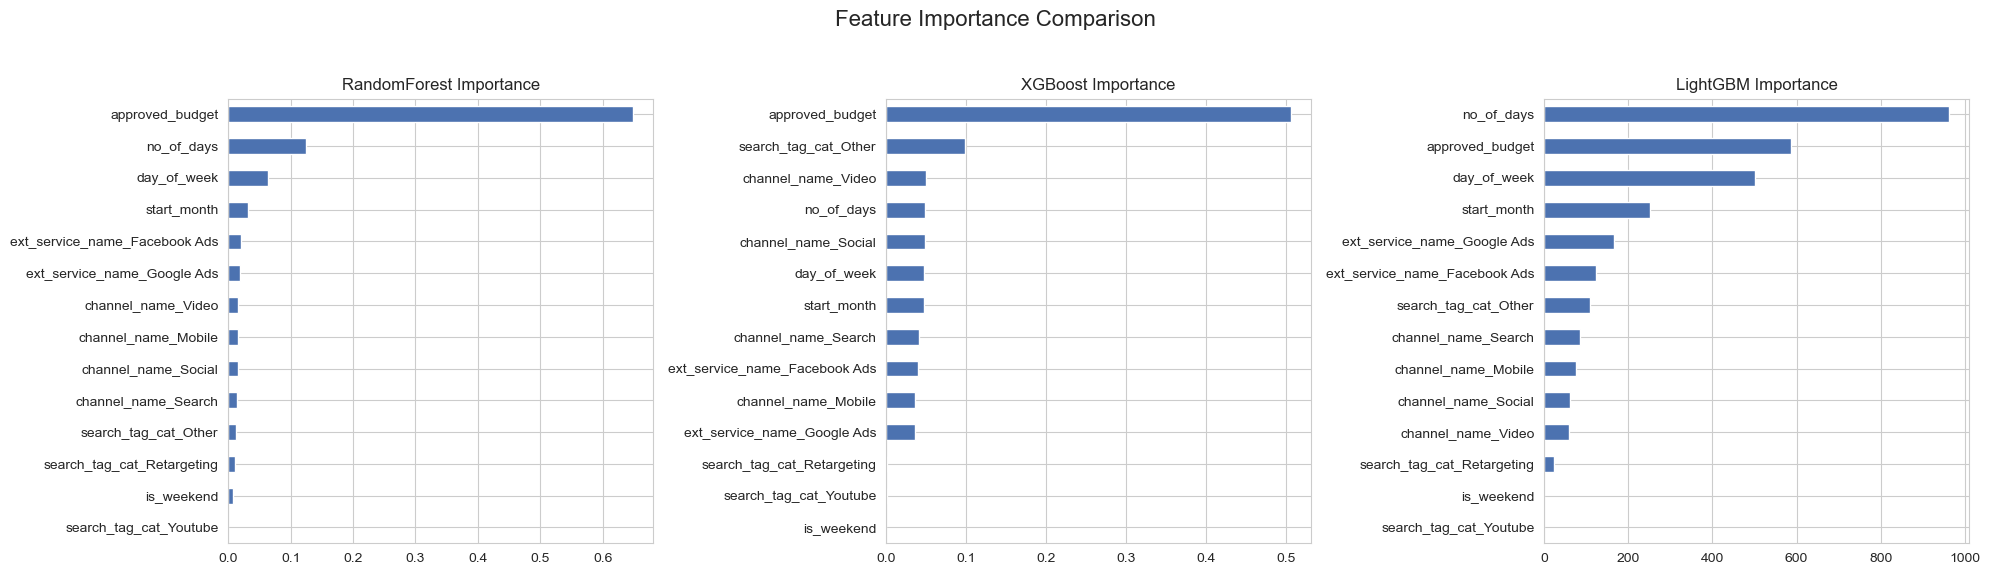

In [55]:
# DEFINE TARGET & LEAKAGE
TARGET = 'overcost'

leakage_cols = [
    TARGET,
    'campaign_item_id',
    'campaign_budget_usd',
    'media_cost_usd',
    'clicks', 'impressions',
    'Unnamed: 0', 'Unnamed__0'
]

cols_to_drop = [c for c in leakage_cols if c in df.columns]
X = df.drop(columns=cols_to_drop)
y = df[TARGET]

print(f"Dropped Leakage: {cols_to_drop}")

# SPLIT DATA (Train/Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\n🔍 Training Inspector Models to compare Feature Importance...")

inspectors = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, objective='reg:squarederror', random_state=42),
    'LightGBM': LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
}

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Feature Importance Comparison', fontsize=16)

for i, (name, model) in enumerate(inspectors.items()):
    print(f"   -> Analyzing with {name}...")
    model.fit(X_train, y_train)
    
    importances = model.feature_importances_
    feat_series = pd.Series(importances, index=X_train.columns)
    
    ax = axes[i]
    feat_series.nlargest(15).plot(kind='barh', ax=ax, color='#4c72b0')
    ax.set_title(f"{name} Importance")
    ax.invert_yaxis()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 4. Hyperparameter Optimization

Performs Randomized Search Cross-Validation to fine-tune hyperparameters for each model. Evaluates the optimized models on Test data and automatically selects the best performer based on the Test R2 Score.

In [56]:
print("\n⚡OPTIMIZED TRAINING")
print("-" * 85)
print(f"{'Model':<15} | {'Test R2':<10} | {'Train R2':<10} | {'Gap':<10} | {'RMSE':<12}")
print("-" * 85)

# Best Settings Based on Experiments
k_best = 10
score_method = mutual_info_regression 

# These represent the best parameters of our tuning experiments
models_to_train = {
    'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42), 
    'XGBoost':      XGBRegressor(n_estimators=100, learning_rate=0.01, max_depth=3, random_state=42),
    'LightGBM':     LGBMRegressor(n_estimators=300, learning_rate=0.01, num_leaves=31, random_state=42, verbose=-1)
}

# Variable to store pipelines for Visualization in Block 6
trained_pipelines = {}

# Tracking variables for the following blocks
best_opt_r2 = -float('inf')
best_opt_model = None
best_model_name = None 
best_opt_rmse = 0

# TRAIN LOOP
for name, model in models_to_train.items():
    
    # Build Pipeline
    pipeline = Pipeline([
        ('selector', SelectKBest(score_func=score_method, k=k_best).set_output(transform="pandas")),
        ('regressor', model)
    ])
    
    # Fit
    pipeline.fit(X_train, y_train)
    
    # Save the full pipeline
    trained_pipelines[name] = pipeline
    
    # Predict
    y_pred_test = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train)
    
    # Metrics
    r2_test = r2_score(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    gap = r2_train - r2_test
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    # Print Row
    print(f"{name:<15} | {r2_test:.4f}     | {r2_train:.4f}     | {gap:.4f}     | ${rmse:,.0f}")
    
    # Track Winner
    if r2_test > best_opt_r2:
        best_opt_r2 = r2_test
        best_opt_rmse = rmse
        best_opt_model = pipeline
        best_model_name = name

print("-" * 85)
print(f"Winner: {best_model_name} (R2: {best_opt_r2:.4f})")

opt_r2 = best_opt_r2
opt_rmse = best_opt_rmse


⚡OPTIMIZED TRAINING
-------------------------------------------------------------------------------------
Model           | Test R2    | Train R2   | Gap        | RMSE        
-------------------------------------------------------------------------------------
RandomForest    | 0.6309     | 0.6476     | 0.0167     | $73,251
XGBoost         | 0.5606     | 0.5585     | -0.0022     | $79,921
LightGBM        | 0.6345     | 0.6824     | 0.0478     | $72,890
-------------------------------------------------------------------------------------
Winner: LightGBM (R2: 0.6345)


## 5. Feature Importance Visualization

Extracts and visualizes the top 5 most influential features for each model. This step show exactly which data points the models are prioritizing for their predictions.

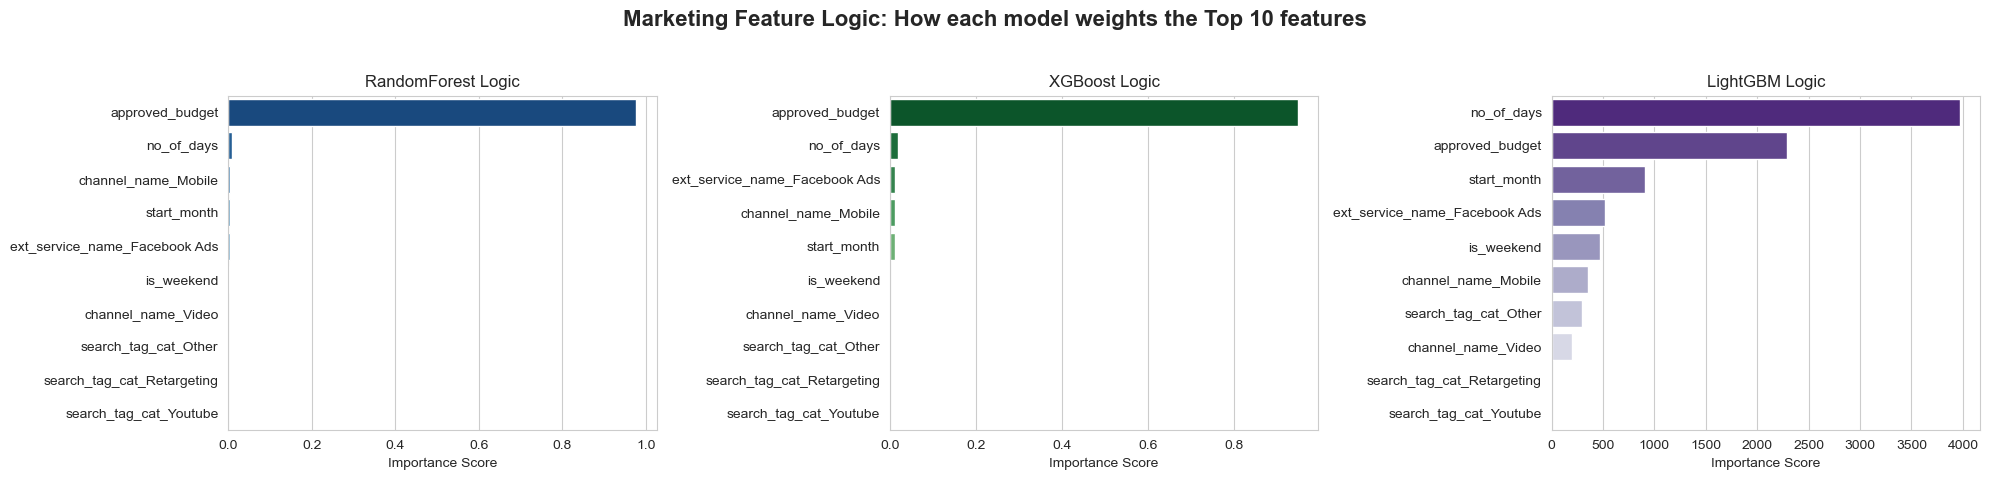


📝 DETAILED FEATURE RANKING PER MODEL (MARKETING):
------------------------------------------------------------

✅ RandomForest Ranking:
                      Feature  Importance
              approved_budget    0.976739
                   no_of_days    0.009567
          channel_name_Mobile    0.005098
                  start_month    0.003675
ext_service_name_Facebook Ads    0.003354
                   is_weekend    0.000807
           channel_name_Video    0.000306
         search_tag_cat_Other    0.000230
   search_tag_cat_Retargeting    0.000225
       search_tag_cat_Youtube    0.000000

✅ XGBoost Ranking:
                      Feature  Importance
              approved_budget    0.947472
                   no_of_days    0.018686
ext_service_name_Facebook Ads    0.011822
          channel_name_Mobile    0.011189
                  start_month    0.010830
                   is_weekend    0.000000
           channel_name_Video    0.000000
         search_tag_cat_Other    0.000000
   

In [57]:
# Setup the Plotting Area
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Marketing Feature Logic: How each model weights the Top 10 features', fontsize=16, fontweight='bold')

color_map = {'RandomForest': 'Blues_r', 'XGBoost': 'Greens_r', 'LightGBM': 'Purples_r'}

# # Loop through trained_pipelines
for i, (name, pipeline) in enumerate(trained_pipelines.items()):
    
    # Extract parts from pipeline
    selector = pipeline.named_steps['selector']
    regressor = pipeline.named_steps['regressor']
    
    # Get Feature Names
    selected_mask = selector.get_support()
    selected_names = X_train.columns[selected_mask]
    
    # Extract Importance
    if hasattr(regressor, 'feature_importances_'):
        importances = regressor.feature_importances_
        
        feat_df = pd.DataFrame({
            'Feature': selected_names,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)

        # Plot
        ax = axes[i]
        sns.barplot(x='Importance', y='Feature', data=feat_df, palette=color_map.get(name, 'viridis'), ax=ax)
        ax.set_title(f"{name} Logic", fontsize=12)
        ax.set_xlabel("Importance Score")
        ax.set_ylabel("") 
    else:
        axes[i].text(0.5, 0.5, f"{name}\nNo Importance Data", ha='center')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Print text versions
print("\n📝 DETAILED FEATURE RANKING PER MODEL (MARKETING):")
print("-" * 60)
for name, pipeline in trained_pipelines.items():
    selector = pipeline.named_steps['selector']
    regressor = pipeline.named_steps['regressor']
    selected_names = X_train.columns[selector.get_support()]
    
    if hasattr(regressor, 'feature_importances_'):
        importances = regressor.feature_importances_
        feat_df = pd.DataFrame({'Feature': selected_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
        print(f"\n✅ {name} Ranking:")
        print(feat_df.to_string(index=False))

## 6. Prediction Evaluation

Selects the best performing model and validates its value by comparing it against a "Naive Baseline" (simply guessing the average conversion rate for everyone).

✅ Evaluating Final Optimized Champion: LightGBM

📊 PERFORMANCE SUMMARY: LIGHTGBM
-----------------------------------------------------------------
1. Baseline RMSE (Assuming $0 Overcost):  $122,468.58
2. AI Model RMSE (Your Prediction):        $72,889.66
-----------------------------------------------------------------
✅ SUCCESS: Your AI is 40.5% more accurate than the baseline!
   Financial Gain: Model reduces error by $49,578.91 per campaign.


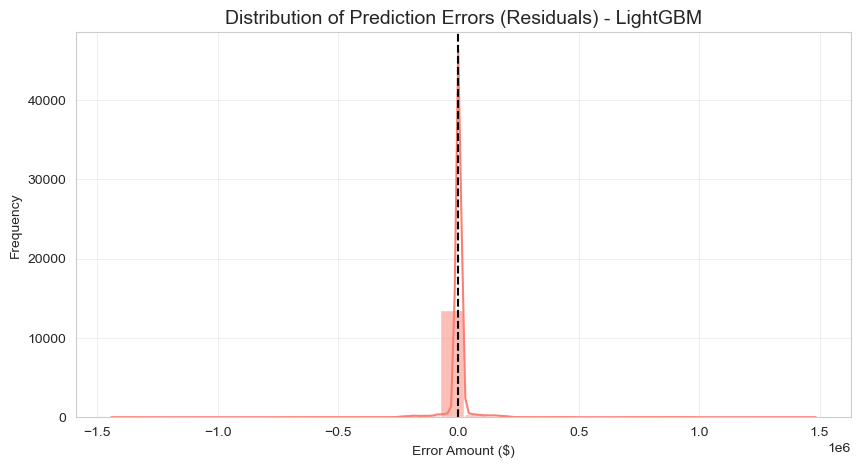

In [58]:
# Select the Best Model
if best_opt_model is not None:
    final_model = best_opt_model
    model_name = best_model_name
    print(f"✅ Evaluating Final Optimized Champion: {model_name}")
else:
    # Fallback safety
    model_name = "LightGBM"
    final_model = trained_pipelines.get(model_name)
    print(f"⚠️ Warning: Using Fallback Model ({model_name}).")

# Get Predictions
y_pred = final_model.predict(X_test)

# Calculate the "Naive" Baseline
# Logic: "If I just assumed every campaign hits budget exactly ($0 overcost), how wrong am I?"
baseline_preds = np.zeros(len(y_test)) 

# Metrics Calculation
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_preds))
model_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
improvement = baseline_rmse - model_rmse
percent_improvement = (improvement / baseline_rmse) * 100 if baseline_rmse != 0 else 0

# PRINT THE REPORT
print(f"\n📊 PERFORMANCE SUMMARY: {model_name.upper()}")
print("-" * 65)
print(f"1. Baseline RMSE (Assuming $0 Overcost):  ${baseline_rmse:,.2f}")
print(f"2. AI Model RMSE (Your Prediction):        ${model_rmse:,.2f}")
print("-" * 65)

if improvement > 0:
    print(f"✅ SUCCESS: Your AI is {percent_improvement:.1f}% more accurate than the baseline!")
    print(f"   Financial Gain: Model reduces error by ${improvement:,.2f} per campaign.")
else:
    print(f"❌ FAIL: The AI is currently worse than just guessing zero.")

# Visualization: Prediction Error Distribution
errors = y_test - y_pred
plt.figure(figsize=(10, 5))
sns.histplot(errors, kde=True, color='salmon', bins=30)
plt.axvline(0, color='black', linestyle='--')
plt.title(f'Distribution of Prediction Errors (Residuals) - {model_name}', fontsize=14)
plt.xlabel('Error Amount ($)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

## 7. Save Model

Persists the final, best performing model to a .joblib file. The filename is automatically versioned with the model type, its R2 accuracy score, and a timestamp to ensure reproducibility and easy tracking of experiments.

In [59]:
#show all columns in order
pd.set_option('display.max_columns', None)
print(X.head())

   no_of_days  approved_budget  start_month  day_of_week  is_weekend  \
0           7            400.0            5            6           1   
1           8            400.0            5            0           0   
2           9            400.0            5            1           0   
3          10            400.0            5            2           0   
4          11            400.0            5            3           0   

   ext_service_name_Facebook Ads  ext_service_name_Google Ads  \
0                              1                            0   
1                              0                            0   
2                              1                            0   
3                              1                            0   
4                              0                            1   

   channel_name_Mobile  channel_name_Search  channel_name_Social  \
0                    1                    0                    0   
1                    0                  

In [60]:
from datetime import datetime

# Generate Timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M")

# Safety Check and Save
if 'best_opt_model' in locals() and best_opt_model is not None:
    filename = f"Marketing_{best_model_name}_Optimized_R2-{opt_r2:.3f}_{timestamp}.joblib"
    
    # Save path
    save_dir = "../Model_Training/Trained_Models/Marketing"
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"📂 Created directory: {save_dir}")
        
    save_path = os.path.join(save_dir, filename)
    
    # Export using joblib
    joblib.dump(best_opt_model, save_path)
    
    print("-" * 65)
    print(f"   Model Type: {best_model_name}")
    print(f"   File Path:  {save_path}")
    print("-" * 65)
else:
    print("❌ ERROR: No optimized model found in memory.")

-----------------------------------------------------------------
   Model Type: LightGBM
   File Path:  ../Model_Training/Trained_Models/Marketing\Marketing_LightGBM_Optimized_R2-0.635_20260118_0310.joblib
-----------------------------------------------------------------
